# Context

Projects have a fixed amount of time/effort available to improve the retrieval pipeline, so you need to prioritize where you spend your effort. You'll want to spend effort on improvements that
1. Affect many queries
2. Affect queries with room for improvement
3. Affect high value queries

This notebook shows how to monitor production traffic and identify what areas to improve (focusing on criteria 1 and 2 above).

Specifically, we use an LLM to categorize queries into different topics or functionality areas. We can do basic analytics to detect
1. Which categories have many queries
2. Which categories have measures of low customer satisfaction

We could do further analytics to look at how these stats change over time (e.g. as we bring in new types of users).

## Load Data

In [1]:
import asyncio
from typing import List
import instructor
import json
from openai import AsyncOpenAI
import pandas as pd

from question_types import (
    UntypedQuestion,
    TypedQuestion,
    Question,
    Product,
    QuestionTypes,
    question_type_details,
)

client = instructor.from_openai(AsyncOpenAI())

def read_to_question(q: dict) -> UntypedQuestion:
    question = Question(text=q["question"])
    product = Product(title=q["product"]["title"], description=q["product"]["description"])
    return UntypedQuestion(question=question, product=product, thumbs_up=q["thumbs_up"], days_ago=q["days_ago"])

with open("prod_questions.json", "r") as f:
    prod_questions = json.load(f)
    untyped_questions = [read_to_question(q) for q in prod_questions]

prod_questions[:2]

/Users/dan/Desktop/systematically-improving-rag/systemic/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


[{'question': 'How does this 16 oz claw hammer compare in weight to the 14 oz ProHammer?',
  'product': {'title': 'Hammer',
   'description': 'This 16 oz claw hammer is perfect for general carpentry and DIY projects. It features a comfortable grip and a durable steel head.'},
  'thumbs_up': True,
  'days_ago': 6},
 {'question': 'Is the grip of this hammer more comfortable than the GripMax 20?',
  'product': {'title': 'Hammer',
   'description': 'This 16 oz claw hammer is perfect for general carpentry and DIY projects. It features a comfortable grip and a durable steel head.'},
  'thumbs_up': False,
  'days_ago': 24}]

# Classifying Queries

The raw query types are defined in `question_types.py`. We include these in our prompt and ask an LLM to categorize each question. We could either categorize each question into a single category or into multiple categories. This example categorizes into a single category.

In [2]:
from pydantic import BaseModel
from typing import List

class QuestionTypeResponse(BaseModel):
    reasoning: str      # For chain of thought reasoning
    question_types: List[QuestionTypes]
    

In [3]:
async_client = instructor.from_openai(AsyncOpenAI())

q_type_explanation_list = [
    f"NAME: {q.title}\nDESCRIPTION: {q.description}\nEXAMPLES:\n`{q.examples[0]}`\n`{q.examples[1]}`"
    for q in question_type_details.values()
]

q_type_explanation_str = "\n\n---\n\n".join(q_type_explanation_list)


async def categorize_question(
    question: UntypedQuestion, semaphore: asyncio.Semaphore = asyncio.Semaphore(1)
) -> TypedQuestion:
    async with semaphore:
        question_text = question.question.text
        prompt = f"""
        Classify the attached question into one or two of the following categories:
        {', '.join([q.value for q in QuestionTypes])}

        Here are descriptions of each category:
        {q_type_explanation_str}

        Here is the question:
        Question: {question_text}

        For your context, here the product is on a hardware store website with the following description:
        {question.product.description}

        Give step-by-step reasoning for why the question belongs in any particular category.
        Use your judgment about whether the correct number of categories is one or two.
        Then give the category name(s) that are the best fit.
        """

        try:
            result = await async_client.chat.completions.create(
                model="gpt-4o-mini",
                response_model=QuestionTypeResponse,
                messages=[{"role": "user", "content": prompt}],
            )
    
            # Discard reasoning and get just the question types
            question_types = [QuestionTypes(q_type) for q_type in result.question_types]

            # For analytics purposes, let a question show up in multiple categories
            return [TypedQuestion(
                question=question.question,
                question_type=q_type,
                product=question.product,
                thumbs_up=question.thumbs_up,
                days_ago=question.days_ago,
            ) for q_type in question_types]
        except Exception as e:
            print(f"Error classifying question: {str(e)}")
            return None

Run this for all questions (using async patterns since we have many questions, and our time will be spent primarily waiting for API responses).

In [4]:

async def categorize_questions(max_concurrency: int = 100) -> List[TypedQuestion]:
    out = []
    semaphore = asyncio.Semaphore(max_concurrency)
    tasks = [categorize_question(q, semaphore) for q in untyped_questions]
    categorized_questions = await asyncio.gather(*tasks, return_exceptions=True)
    for cq in categorized_questions:
        if not isinstance(cq, Exception):
            out.extend(cq)
        else:
            print(f"Error categorizing question: {str(cq)}")
    return out


categorized_questions = await categorize_questions()

# Analytics

Convert the data into a DataFrame and calculate basic statistics

In [5]:
def show_question_analytics(categorized_questions: List[TypedQuestion]):
    clustered_questions = pd.DataFrame(
    [
        {
            "question_text": q.question.text,
            "question_type": q.question_type.value,
            "product_title": q.product.title,
            "thumbs_up": q.thumbs_up,
            "days_ago": q.days_ago,
        }
        for q in categorized_questions
        if q is not None
    ]
    )
    
    cluster_stats = (
    clustered_questions.groupby("question_type")
    .agg(
        num_questions=("question_text", "size"),
        fraction_thumbs_up=("thumbs_up", "mean"),
        count_not_thumbs_up=("thumbs_up", lambda x: x.size - x.sum()),
        questions_in_last_week = ("days_ago", lambda x: (x <= 7).sum()),
    )
    .reset_index()
    )

    return cluster_stats.round(2).sort_values("num_questions", ascending=False)

cluster_stats = show_question_analytics(categorized_questions)
cluster_stats

,question_type,num_questions,fraction_thumbs_up,count_not_thumbs_up,questions_in_last_week
2,Comparison,1003,0.17,837,261
7,Materials,773,0.20,619,211
3,Compatibility,648,0.69,203,167
6,Environmental Impact,619,0.13,540,161
4,Country of Origin,535,0.63,197,219
11,Vague,468,0.68,149,110
1,Authenticity and counterfeits,449,0.11,398,225
5,Customer Service,399,0.63,146,120
10,TypicalPrice,398,0.32,271,65
12,Visual,382,0.10,344,98


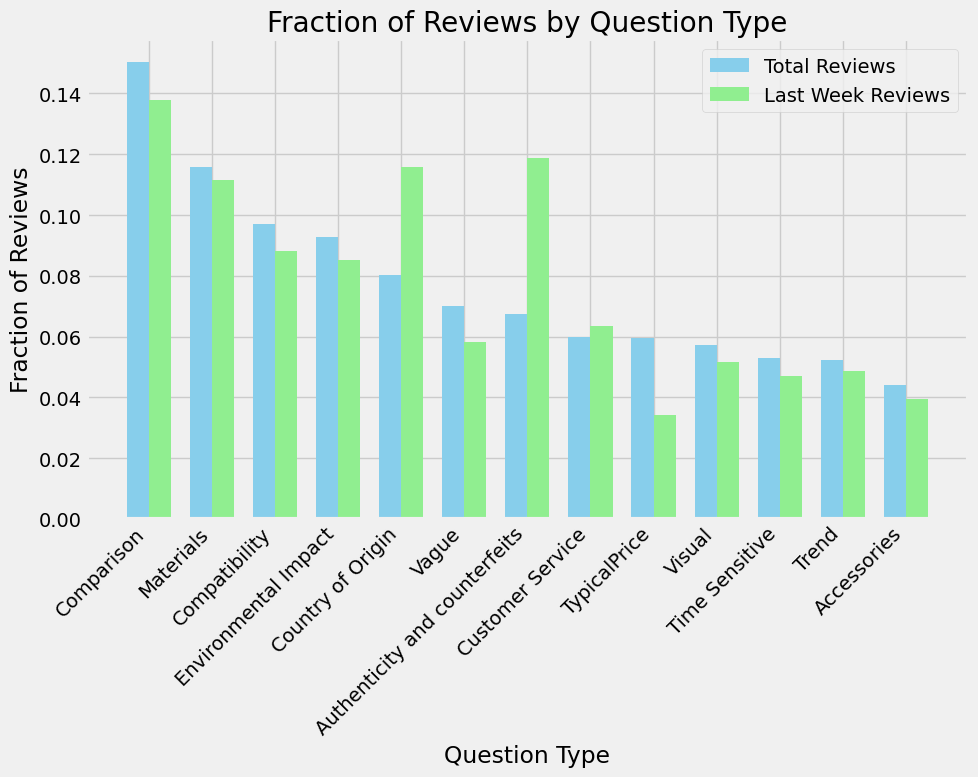

In [6]:
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

def plot_review_fractions(df):
    total_reviews = df['num_questions'].sum()
    total_reviews_last_week = df['questions_in_last_week'].sum()

    df['fraction_reviews'] = df['num_questions'] / total_reviews
    df['fraction_reviews_last_week'] = df['questions_in_last_week'] / total_reviews_last_week

    fig, ax = plt.subplots(figsize=(10, 8))

    width = 0.35
    x = range(len(df))

    ax.bar(x, df['fraction_reviews'], width, label='Total Reviews', color='skyblue')
    ax.bar([p + width for p in x], df['fraction_reviews_last_week'], width, label='Last Week Reviews', color='lightgreen')

    ax.set_xlabel('Question Type')
    ax.set_ylabel('Fraction of Reviews')
    ax.set_title('Fraction of Reviews by Question Type')
    ax.set_xticks([p + width/2 for p in x])
    ax.set_xticklabels(df['question_type'], rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

plot_review_fractions(cluster_stats)

# Conclusion

What areas would you prioritize?

Some candidates:
- Allow combining reviews across products since cross-product comparisons are common and poorly served (biggest source of thumbs down)
- If you run a platform with many sellers (e.g. Amazon), allow filtering by seller within a given SKU. This may help address `Counterfeits`. It is common, poorly served, and is getting more common
- Materials is also a major source of thumbs down. If you have that data, you might consider adding it even though it's not in reviews


Exact prioritization depends on how much effort each potential improvement requires, how effective you expect it to be, etc.